Postal Code to Polygon Finder

Used postal code input: 76829
Polygon Data retrieved: {'_id': ObjectId('65be3e78c4cb36f967a5d5f5'), 'postal_code': '76829', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[7.9752133, 49.1732858], [7.974761, 49.1737483], [7.9745777, 49.1750368], [7.9750703, 49.1755712], [7.9752567, 49.1758731], [7.9751837, 49.1762651], [7.9747462, 49.1765776], [7.9743168, 49.1769113], [7.9742033, 49.1777111], [7.9739279, 49.1780342], [7.973936, 49.1782884], [7.9744075, 49.1786428], [7.9752585, 49.1791243], [7.9762231, 49.1794266], [7.9773337, 49.1799487], [7.9777295, 49.180671], [7.977611, 49.1815022], [7.9778055, 49.1817459], [7.9780068, 49.1819241], [7.9790671, 49.1821559], [7.9832575, 49.1830718], [7.9825283, 49.1838556], [7.9845721, 49.1850394], [7.9839519, 49.1866009], [7.9839894, 49.1868261], [7.9842094, 49.1873258], [7.9838827, 49.1896304], [7.9838151, 49.1898817], [7.983689, 49.1901192], [7.9835093, 49.1903059], [7.9829072, 49.1908365], [7.9815191, 49.1914435], [7.9803872, 49.1920816], [

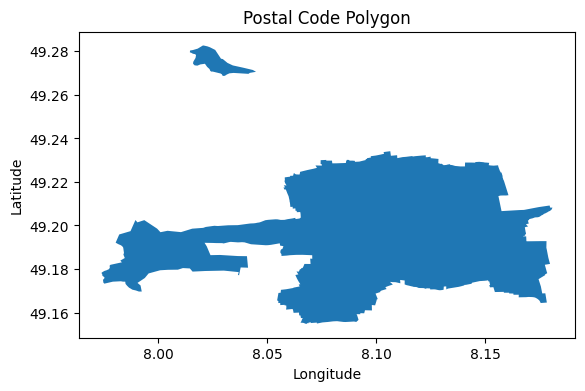

In [1]:
import osmnx as ox
import geopandas as gpd
from pymongo import MongoClient
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"


def connect_to_mongodb(database_name, collection_name):
    """
    Connects to MongoDB and returns the MongoDB client and collection.
    """
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection


def get_polygon_from_result(result):
    """
    Retrieves Shapely Polygon or MultiPolygon from MongoDB result.
    """
    # Check if there is no result for the given postal code
    if result is None:
        raise UserWarning("No geometry for the given postal code")

    # Check if the geometry type is a Polygon
    elif result["geometry"]["type"] == "Polygon":
        # Create a Shapely Polygon object using the exterior coordinates of the polygon
        shapely_geometry = Polygon(result["geometry"]["coordinates"][0])

    # Check if the geometry type is a MultiPolygon
    elif result["geometry"]["type"] == "MultiPolygon":
        # Create a list of Shapely Polygons using the coordinates of the individual polygons
        polygons = [Polygon(poly_coords[0]) for poly_coords in result["geometry"]["coordinates"]]
        # Create a Shapely MultiPolygon object from the list of Polygons
        shapely_geometry = MultiPolygon(polygons)

    # Handle other geometry types if needed
    else:
        raise UserWarning("Unsupported geometry type")

    return shapely_geometry


def retrieve_polygon_by_postal_code(collection, postal_code):
    """
    Retrieves the polygon for a given postal code from MongoDB using a geospatial query.
    """
    document = collection.find_one({"postal_code": postal_code})

    if document:
        shapely_geometry = get_polygon_from_result(document)
        return shapely_geometry, document
    else:
        print(f"No polygon found for postal code: {postal_code}")
        return None, None


def plot_polygon(polygon):
    """
    Plots the given polygon.
    """
    if polygon:
        gdf = gpd.GeoDataFrame(geometry=[polygon])
        gdf.plot()
        plt.title("Postal Code Polygon")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()


def query_and_plot_polygon(database_name, collection_name):
    # Connect to MongoDB
    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    # Input the postal code you want to query
    input_postal_code = input("Enter a postal code: ")

    # Retrieve the polygon and data for the specified postal code
    selected_polygon, selected_polygon_data = retrieve_polygon_by_postal_code(mongo_collection, input_postal_code)

    # Print the used postal code input
    print(f"Used postal code input: {input_postal_code}")
    print(f"Polygon Data retrieved: {selected_polygon_data}")

    # Plot the retrieved polygon
    plot_polygon(selected_polygon)

    # Close MongoDB connection when done
    mongo_client.close()


# Example usage
query_and_plot_polygon(database_name="Polygon_By_Postal_Code_DB", collection_name="Polygon_By_Postal_Code_Collection")


---

Coordinate to nearest Postal Code & Polygon

In [2]:
import osmnx as ox
import geopandas as gpd
from pymongo import MongoClient
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.pyplot as plt

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"


def connect_to_mongodb(database_name, collection_name):
    """
    Connects to MongoDB and returns the MongoDB client and collection.
    """
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection


def retrieve_data_from_mongodb(collection, point):
    """
    Retrieves GeoJSON data from MongoDB collection using a geospatial query based on the specified point.
    """
    query = {
        "geometry": {
            "$geoIntersects": {
                "$geometry": {
                    "type": "Point",
                    "coordinates": [point.x, point.y]
                }
            }
        }
    }

    cursor = collection.find(query)
    geojson_data = {"type": "FeatureCollection", "features": list(cursor)}

    return geojson_data


def get_polygon_from_result(result):
    """
    Retrieves Shapely Polygon or MultiPolygon from MongoDB result.
    """
    # Check if there is no result for the given point
    if not result['features']:
        raise UserWarning("No geometry for the given point")

    coordinates = result['features'][0]['geometry']['coordinates'][0]

    # Check if coordinates are nested (indicating a polygon with holes)
    if isinstance(coordinates[0][0], list):
        # Create a MultiPolygon
        return MultiPolygon([Polygon(part) for part in coordinates])
    else:
        # Create a Polygon
        return Polygon(coordinates)


def plot_polygon(polygon):
    """
    Plots a Shapely Polygon.
    """
    gdf = gpd.GeoDataFrame(geometry=[polygon])
    gdf.plot()
    plt.title("Postal Code Polygon")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


if __name__ == "__main__":
    # MongoDB configuration
    database_name = "ZIP_Poly_DB_GeoJson_Test"
    collection_name = "ZIP_Poly_Collection_GeoJson_Test"

    # Input latitude and longitude for the point
    latitude = float(51.316669)
    longitude = float(9.500000)

    # Create a Point object for the specified latitude and longitude
    point = Point(longitude, latitude)

    # Connect to MongoDB
    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    # Retrieve GeoJSON data from MongoDB based on the specified point
    geojson_data_from_mongo = retrieve_data_from_mongodb(mongo_collection, point)

    # Plot the retrieved polygon
    if geojson_data_from_mongo['features']:
        selected_polygon = get_polygon_from_result(geojson_data_from_mongo)
        plot_polygon(selected_polygon)
        print(f"The postal code for the point ({latitude}, {longitude}) is: {geojson_data_from_mongo['features'][0]['properties']['postal_code']}")
        # Access the selected polygon as needed
        print("Selected Polygon Information:")
        print(selected_polygon)
    else:
        print(f"No postal code found for the point ({latitude}, {longitude}).")

    # Close MongoDB connection when done
    mongo_client.close()


No postal code found for the point (51.316669, 9.5).


---

MultiPolygon Finder

In [3]:
import osmnx as ox
from pymongo import MongoClient

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"

def connect_to_mongodb(database_name, collection_name):
    """
    Connects to MongoDB and returns the MongoDB client and collection.
    """
    client = MongoClient('localhost', 27017)
    db = client[database_name]
    collection = db[collection_name]
    return client, collection

def find_multipolygon_postal_codes(collection, num_postal_codes):
    """
    Finds the specified number of documents with MultiPolygons in the MongoDB collection.
    Returns a list of postal codes if found, otherwise returns an empty list.
    """
    query = {"geometry.type": "MultiPolygon"}
    projection = {"properties.postal_code": 1}

    cursor = collection.find(query, projection).limit(num_postal_codes)

    postal_codes = [document.get('properties', {}).get('postal_code') for document in cursor]

    return postal_codes

def query_and_print_multipolygon_postal_codes(database_name, collection_name):
    # Connect to MongoDB
    mongo_client, mongo_collection = connect_to_mongodb(database_name, collection_name)

    # Specify the number of postal codes to find
    num_postal_codes_to_find = int(input("Enter the number of postal codes to find: "))

    # Find the specified number of documents with MultiPolygons
    multipolygon_postal_codes = find_multipolygon_postal_codes(mongo_collection, num_postal_codes_to_find)

    if multipolygon_postal_codes:
        print(f"The postal codes for the first {num_postal_codes_to_find} documents with MultiPolygons are: {multipolygon_postal_codes}")
    else:
        print(f"No documents with MultiPolygons found in the collection.")

    # Close MongoDB connection when done
    mongo_client.close()

# Example usage
if __name__ == "__main__":
    database_name = "ZIP_Poly_DB_GeoJson_Test"
    collection_name = "ZIP_Poly_Collection_GeoJson_Test"

    query_and_print_multipolygon_postal_codes(database_name, collection_name)


No documents with MultiPolygons found in the collection.
